# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of universal statistical simulator can be found here.

## Part II - General Algorithm for Quantum Galton Box

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
SHOTS = 1024

In [5]:
get_device = lambda n: qml.device("default.qubit", wires=2*n+2, shots=SHOTS)

In [6]:
def calculate_wire_tuples(n, level) -> list:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i+1) for i in range(middle - level, middle + level)]

In [7]:
def run_circuit(circuit_generator, n, coin_function, reverse=False):
    my_circuit = circuit_generator(n, coin=coin_function)
    samples = my_circuit()
    bitstrings = ["".join(str(bit) for bit in sample) for sample in samples]
    freqs = Counter(bitstrings)
    freqs = dict(sorted(freqs.items(), reverse=reverse))
    return freqs

In [8]:
def plot_freqs(freqs, title, reference_values=None):
    """Plots the frequencies of bitstrings as a histogram, with optional reference line."""
    plt.bar(freqs.keys(), freqs.values(), label="Quantum Galton Box")
    if reference_values is not None:
        plt.plot(list(freqs.keys()), reference_values, color="red", marker="o", linestyle="-", label="Reference")
    plt.xlabel("Bitstring")
    plt.ylabel("Frequency")
    plt.title(title)
    if reference_values is not None:
        plt.legend()
    plt.show()

In [67]:
def create_qgb_circuit(n, coin):
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    dev = get_device(n)
        
    def qpegs(wire_tuples):
        for i, wires in enumerate(wire_tuples):
            qml.CSWAP(wires=[0, wires[0], wires[1]])
            if i < len(wire_tuples) - 1:
                qml.CNOT(wires=[wires[1], 0])
    

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n+1)
        for level in range(1, n+1):
            coin(level)
            qpegs(wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qml.measure(wires=0, reset=True)
        return qml.sample(wires=range(1, 2*n+2, 2))
    
    return qgb_circuit


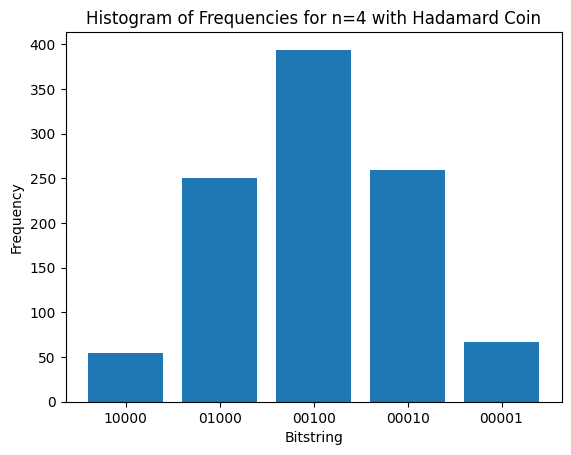

In [68]:
n = 4
coin_function = lambda level: qml.Hadamard(wires=0)
freqs = run_circuit(create_qgb_circuit, n, coin_function, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Hadamard Coin")

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

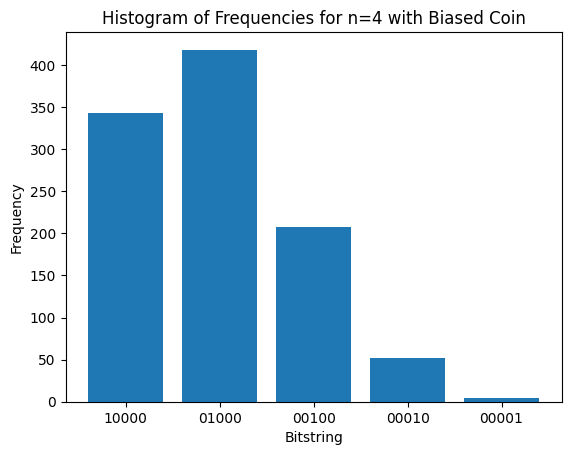

In [69]:
n = 4
coin_function = lambda level: qml.RY(2*np.pi/3, 0)
freqs = run_circuit(create_qgb_circuit, n, coin_function, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Biased Coin")

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [70]:
def exponential_coin(level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * np.acos(np.sqrt(1 / np.e)) 
    if level == 1:
        qml.RY(theta, wires=0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qml.CNOT(wires=[i, 0])
        qml.CRY(theta, wires=[middle + level - 1, 0])

[600 275 103  33   8]


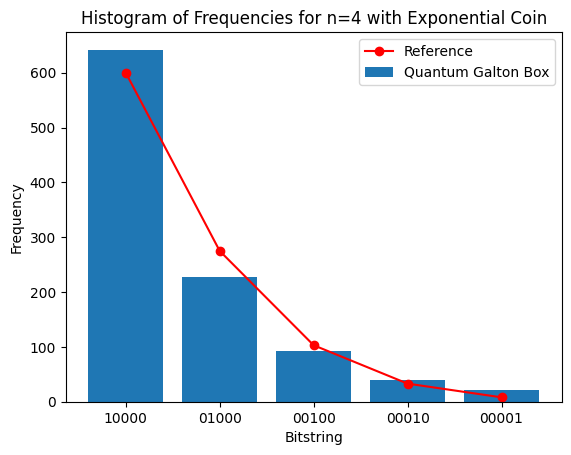

In [71]:
n = 4
exp_samples = np.random.exponential(scale=1, size=SHOTS)
reference_freqs = np.arange(0, n+2)

reference_freqs = np.histogram(exp_samples, bins=reference_freqs, density=False)[0]
print(reference_freqs)
freqs = run_circuit(create_qgb_circuit, n, exponential_coin, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Exponential Coin", reference_values=reference_freqs)

In [72]:
#circuit = create_qgb_circuit(3, coin=exponential_coin)
#qml.draw_mpl(circuit, show_all_wires=True)()

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [34]:
def calculate_wire_tuples(n, level) -> list:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i+1) for i in range(middle - level, middle + level)]


def create_qgb_hrw_circuit(n, coin):
    """Creates a quantum circuit for the Hadamard Random Walk on Quantum Galton Board (QGB) with n levels."""

    dev = get_device(n)
        
    def qpegs(wire_tuples):
        control_value = 1
        for wires in wire_tuples:
            qml.ctrl(qml.SWAP, control=0, control_values=control_value)(wires=wires)
            control_value ^= 1
    

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n+1)
        coin(1)
        for level in range(1, n+1):
            qpegs(wire_tuples=calculate_wire_tuples(n, level))
        return qml.sample(wires=range(1, 2*n+2, 2))
    
    return qgb_circuit

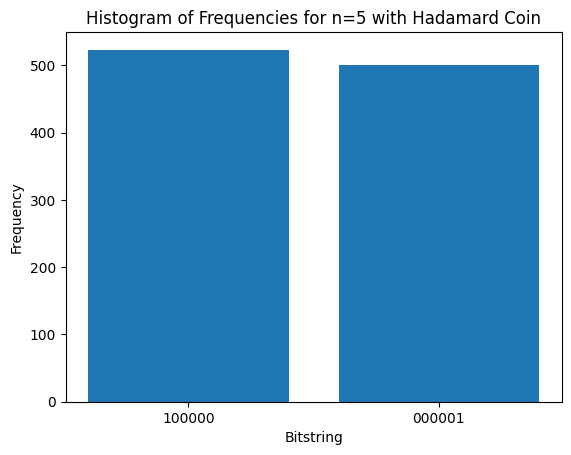

In [35]:
n = 5
coin_function = lambda level: qml.Hadamard(wires=0)
freqs = run_circuit(create_qgb_hrw_circuit, n, coin_function, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Hadamard Coin")

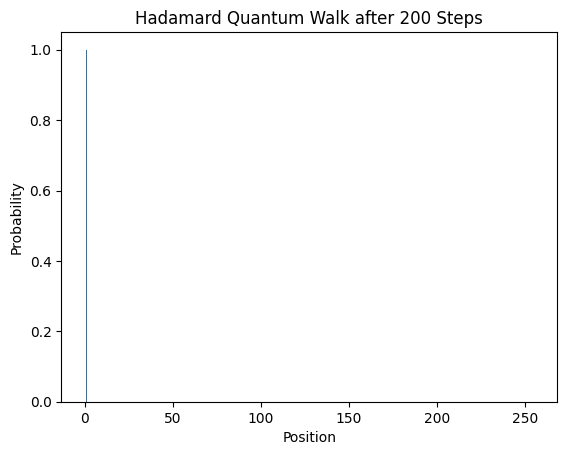

In [97]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
n_position_qubits = 8  # 2^3 = 8 positions
n_total = 1 + n_position_qubits  # 1 coin qubit + position qubits
steps = 200  # number of quantum walk steps

# --- Device ---
dev = qml.device("default.qubit", wires=n_total)

# --- Wire setup ---
coin = 0
positions = list(range(1, n_total))  # [1, 2, 3]

# --- Modular Increment ---
def increment():
    n = len(positions)
    for i in range(n):
        qml.X(wires=positions[i])
        for j in range(i):
            qml.CNOT(wires=[positions[j], positions[i]])

# --- Modular Decrement ---
def decrement():
    n = len(positions)
    for i in reversed(range(n)):
        for j in range(i):
            qml.CNOT(wires=[positions[j], positions[i]])
        qml.X(wires=positions[i])

# --- One Step of the Hadamard Walk ---
def hadamard_walk_step():
    #qml.Hadamard(wires=coin)
    qml.ctrl(decrement, control=coin, control_values=[0])()
    qml.ctrl(increment, control=coin, control_values=[1])()

# --- Full Circuit ---
@qml.qnode(dev)
def run_quantum_walk():
    # Optional: create coin in equal superposition
    qml.Hadamard(wires=coin)

    # Initialize walker at position 0 (|000⟩)
    # Already initialized to |0⟩ so nothing needed

    for _ in range(steps):
        hadamard_walk_step()

    return qml.probs(wires=positions)

# --- Run and Plot ---
probs = run_quantum_walk()
positions_list = list(range(len(probs)))

plt.bar(positions_list, probs)
plt.xlabel("Position")
plt.ylabel("Probability")
plt.title(f"Hadamard Quantum Walk after {steps} Steps")
plt.show()


Position -10: Probability = 0.000977
Position -9: Probability = 0.000000
Position -8: Probability = 0.064453
Position -7: Probability = 0.000000
Position -6: Probability = 0.262695
Position -5: Probability = 0.000000
Position -4: Probability = 0.062500
Position -3: Probability = 0.000000
Position -2: Probability = 0.074219
Position -1: Probability = 0.000000
Position  0: Probability = 0.070312
Position  1: Probability = 0.000000
Position  2: Probability = 0.074219
Position  3: Probability = 0.000000
Position  4: Probability = 0.062500
Position  5: Probability = 0.000000
Position  6: Probability = 0.262695
Position  7: Probability = 0.000000
Position  8: Probability = 0.064453
Position  9: Probability = 0.000000
Position 10: Probability = 0.000977


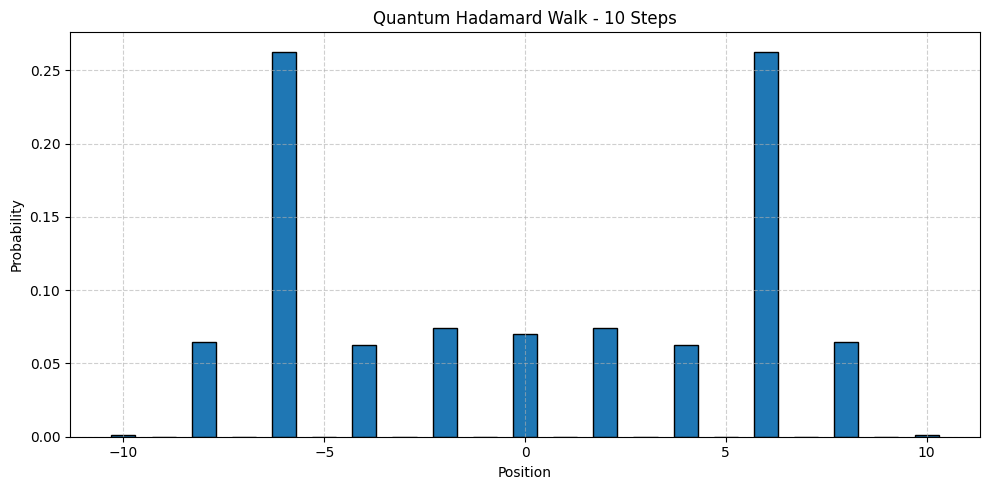

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def hadamard():
    """Return the Hadamard matrix."""
    return np.array([[1, 1], [1, -1]]) / np.sqrt(2)

def quantum_hadamard_walk(num_steps):
    """Simulate a 1D quantum Hadamard walk for a given number of steps."""
    position_range = 2 * num_steps + 1
    mid = position_range // 2

    # Initialize state: coin |0>, position 0
    state = np.zeros((2, position_range), dtype=complex)
    state[:, mid] = np.array([1, 1j]) / np.sqrt(2)

    H = hadamard()

    # Perform the walk
    for _ in range(num_steps):
        # Apply Hadamard to coin state at each position
        coin_transformed = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            coin_state = state[:, pos]
            coin_transformed[:, pos] = H @ coin_state

        # Apply conditional shift based on coin state
        new_state = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            for coin in [0, 1]:
                shift = -1 if coin == 0 else 1
                new_pos = pos + shift
                if 0 <= new_pos < position_range:
                    new_state[coin, new_pos] += coin_transformed[coin, pos]
        state = new_state

    # Compute normalized probabilities at each position
    total_prob = np.sum(np.abs(state)**2)
    probabilities = np.sum(np.abs(state)**2, axis=0) / total_prob
    positions = np.arange(-num_steps, num_steps + 1)

    return positions, probabilities

def plot_distribution(positions, probabilities, num_steps):
    """Plot the probability distribution."""
    plt.figure(figsize=(10, 5))
    plt.bar(positions, probabilities, width=0.6, edgecolor='black')
    plt.title(f"Quantum Hadamard Walk - {num_steps} Steps")
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

num_steps = 10  # You can change this
positions, probabilities = quantum_hadamard_walk(num_steps)
for pos, prob in zip(positions, probabilities):
    print(f"Position {pos:2d}: Probability = {prob:.6f}")
plot_distribution(positions, probabilities, num_steps)
